In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import data,filters
import scipy.ndimage as ndimage
import numpy as np
from PIL import Image
from math import floor, ceil
import pandas as pd
import cv2
import os

image = plt.imread("greenscreen.jpg")
cat =plt.imread("cat.jpg")
cat_background = cat[130:505,200:700,:]
orb = cv2.ORB_create()
minHessian = 400
surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
cathedral = cv2.imread('cathedral.jpg')
cathedral = cv2.cvtColor(cathedral, cv2.COLOR_BGR2RGB)
cathedral_1 = cv2.imread('cathedral1.jpg')
cathedral_1 = cv2.cvtColor(cathedral_1, cv2.COLOR_BGR2RGB)
semper0 = plt.imread("semper0.jpg")
semper1 = plt.imread("semper1.jpg")

# Question 1
# Get mask where green is in the threshold and also
# where greens are smaller than either of the other colours
mask = (image[:, :, 1] < 175) | (image[:, :, 2] > image[:, :, 1]) | (image[:, :, 0] > image[:, :, 1])
# Get Inverse mask
un_mask = np.invert(mask)
green = np.zeros_like(image, np.uint8)
green[mask] = image[mask]
def display_1():
    green[un_mask] = cat_background[un_mask]
    plt.axis('off')
    plt.imshow(green)
    
# Question2
grey= Image.open('lena_gray.gif').convert("L")
grey = np.asarray(grey).astype(float)
# Blur image
smoothed_grey = ndimage.gaussian_filter(grey, sigma=(1.5))
mask = grey - smoothed_grey
masked = grey + mask
smoothed_grey = smoothed_grey.astype(np.uint8)
grey = grey.astype(np.uint8)
mask = mask.astype(np.uint8)
masked = masked.astype(np.uint8)

# display question 2
def display_2():
    plt.axis('off')
    print("Original picture:")
    plt.imshow(grey, cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Smoothed with Gaussian filter:")
    plt.imshow(smoothed_grey,cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Mask:")
    plt.imshow(mask,cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.axis('off')
    print("Final Result:")
    plt.imshow(masked,cmap='gray')
    plt.show()

# Question 3
def nn_resize(base_image, scale):
    print("Starting Nearest Neighbour")
    x_scale = int(scale*base_image.shape[0])
    y_scale = int(scale*base_image.shape[1])
    resized = np.zeros((x_scale,y_scale,3),  dtype=np.uint8)
    for x in range(0, x_scale):
        for y in range(0, y_scale):
            x_old = int(round(x/scale))
            if x_old >= base_image.shape[0] - 1:
                x_old = base_image.shape[0] - 1
            y_old = int(round(y/scale))
            if y_old >= base_image.shape[1] - 1:
                y_old = base_image.shape[1] - 1
            resized[x, y, :] =  base_image[x_old,y_old,:]
    print("Done resizing")
    return resized
def display_3_nn():
    # Enlarge
    print("Scale = 3.1")
    large_nn = nn_resize(cat, 3.1)
    cat_nn = large_nn
    plt.imshow(large_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Enlarge more
    print("Scale = 10")
    large_nn = nn_resize(cat, 10)
    plt.imshow(large_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink
    print("Scale = 0.9")
    small_nn = nn_resize(cat, 0.9)
    plt.imshow(small_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink more
    print("Scale = 0.1")
    small_nn = nn_resize(cat, 0.1)
    plt.imshow(small_nn)
    plt.show()
    plt.imshow(cat)
    plt.show()
    return cat_nn

def bl_resize(base_image, scale):
    print("Starting Bilinear Interpolation")
    x_scale = int(scale * base_image.shape[0])
    y_scale = int(scale * base_image.shape[1])
    resized = np.zeros((x_scale, y_scale, 3), dtype=np.uint8)
    for x in range(0, x_scale):
        for y in range(0, y_scale):
            x_old = x / scale
            if x_old >= base_image.shape[0] - 1:
                x_old = base_image.shape[0] - 1
            y_old = y / scale
            if y_old >= base_image.shape[1] - 1:
                y_old = base_image.shape[1] - 1
            xf = int(floor(x_old))
            xc = int(ceil(x_old))
            yf = int(floor(y_old))
            yc = int(ceil(y_old))
            c_ff = base_image[xf, yf, :].astype(dtype=int)
            c_cf = base_image[xc, yf, :].astype(dtype=int)
            c_fc = base_image[xf, yc, :].astype(dtype=int)
            c_cc = base_image[xc, yc, :].astype(dtype=int)
            if y_old == yc and x_old == xc:
                # color is the same        
                resized[x, y, :] = base_image[xc,yc,:]
            elif y_old == yc:
                resized[x, y, :] = (
                    0.5*
                    ((xc-x_old)*c_ff + (x_old - xf)*c_cf)
                    +
                    0.5*
                    ((xc-x_old)*c_fc + (x_old - xf)*c_cc)
                ).astype(np.uint8)
            elif x_old == xc:
                # Same x
                resized[x, y, :] = (
                    (yc - y_old)*
                    (0.5*c_ff + 0.5*c_cf)
                    +
                    (y_old -yf)*
                    (0.5*c_fc + 0.5*c_cc)
                ).astype(np.uint8)
            else:
                # Same y
                resized[x, y, :] = (
                    (yc - y_old)*
                    ((xc-x_old)*c_ff + (x_old - xf)*c_cf)
                    +
                    (y_old -yf)*
                    ((xc-x_old)*c_fc + (x_old - xf)*c_cc)
                ).astype(np.uint8)
    print("Done resizing")
    return resized

def display_3_bl():
    # Enlarge
    print("Scale = 3.1")
    large_bl = bl_resize(cat, 3.1)
    cat_bl = large_bl
    plt.imshow(large_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Enlarge more
    print("Scale = 10")
    large_bl = bl_resize(cat, 10)
    plt.imshow(large_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink
    print("Scale = 0.9")
    small_bl = bl_resize(cat, 0.9)
    plt.imshow(small_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    # Shrink more
    print("Scale = 0.1")
    small_bl = bl_resize(cat, 0.1)
    plt.imshow(small_bl)
    plt.show()
    plt.imshow(cat)
    plt.show()
    return cat_bl

def compare_nn_bl():
    print("Nearest Neighbour Interpolation:")
    plt.imshow(cat_nn[600:610, 2100:2110, :])
    plt.show()
    print("Bilinear Interpolation:")
    plt.imshow(cat_bl[600:610, 2100:2110, :])
    plt.show()
    


# Computer Vision Assignment 1
**Michael Shepherd - 19059019**
## Question 1

Separate the actors from the green background in the image greenscreen.jpg by thresholding the different
colour channels in a suitable way. Then place the actors on top of some other (more interesting) background
of your own choosing.

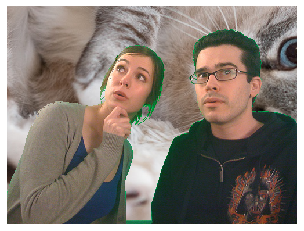

In [2]:
display_1()

## Question 2

Perform unsharp masking on a greyscale image of your own choosing. You will observe that the output
image may contain values outside [0, 255]. Why is that? What would be better — to scale all the intensities
of the output, or to simply truncate only those values outside the interval?

Original picture:


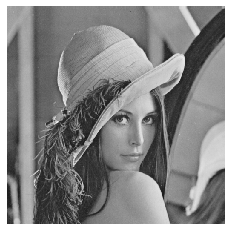

Smoothed with Gaussian filter:


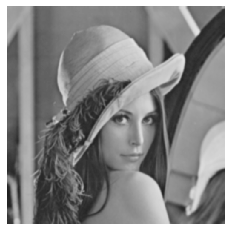

Mask:


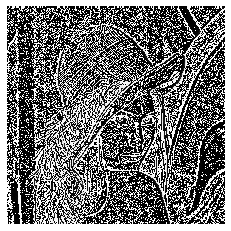

Final Result:


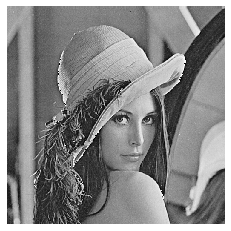

In [3]:
display_2()

What would be better — to scale all the intensities of the output, or to simply truncate only those values outside the interval?

TODO

## Question 3

Create a function that will take a colour image as input and scale (resize) it by a given factor s. Implement
both nearest neighbour (NN) and bilinear (BL) interpolation. Pick a colour image as input and show a
handful of results for different s, using both NN and BL interpolation. Show at least one close-up where
the difference between NN and BL is clear.

### Nearest Neighbour

Scale = 3.1
Starting Nearest Neighbour
Done resizing


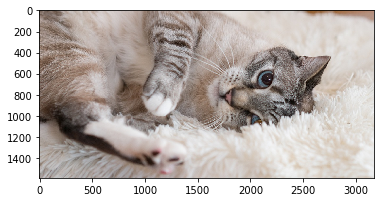

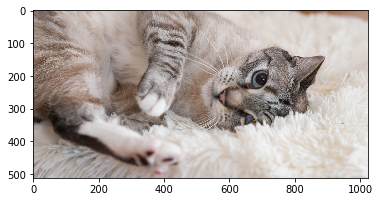

Scale = 10
Starting Nearest Neighbour
Done resizing


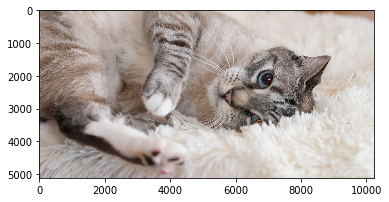

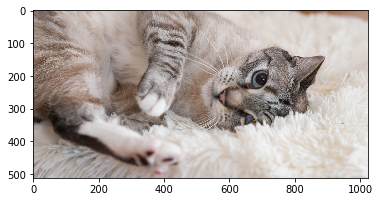

Scale = 0.9
Starting Nearest Neighbour
Done resizing


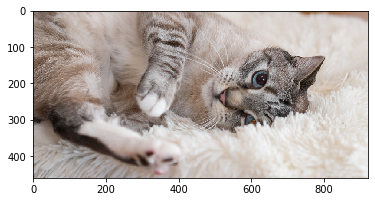

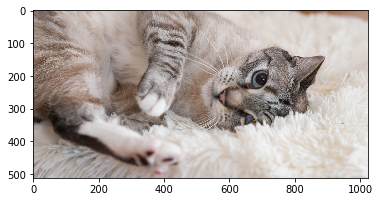

Scale = 0.1
Starting Nearest Neighbour
Done resizing


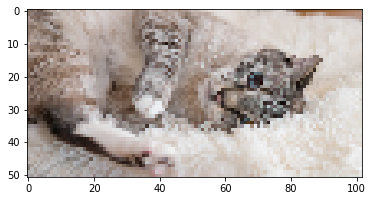

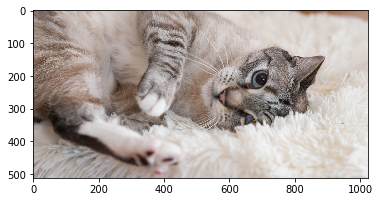

In [4]:
# cat_nn = display_3_nn()

### Bilinear Interpolation

Scale = 3.1
Starting Bilinear Interpolation
Done resizing


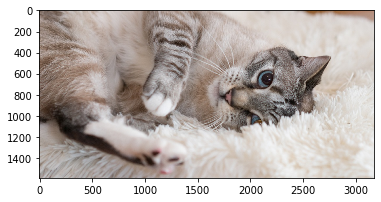

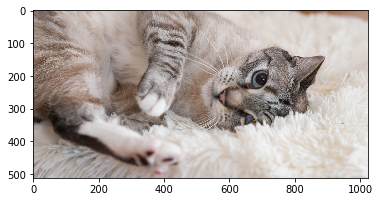

Scale = 10
Starting Bilinear Interpolation
Done resizing


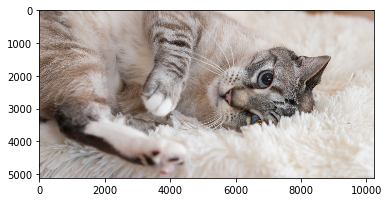

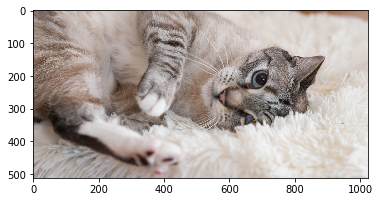

Scale = 0.9
Starting Bilinear Interpolation
Done resizing


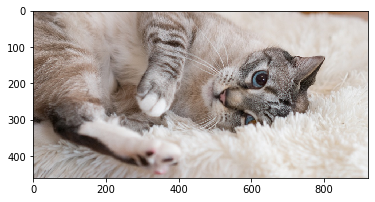

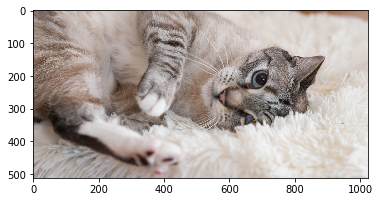

Scale = 0.1
Starting Bilinear Interpolation
Done resizing


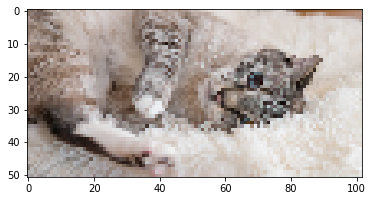

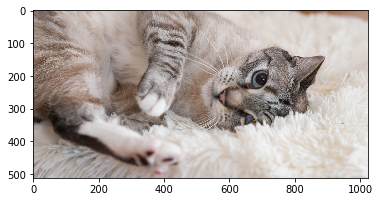

In [5]:
# cat_bl = display_3_bl()

### Comparison
To compare how the two methods of interpolation result in very different final images, we will take the eyeball of this cat after being scaled by x3.1.

In [5]:
# compare_nn_bl()

## Question 4a
Find, download and/or install any decent image feature detector and matcher (for example SIFT,
SURF, FAST, BRIEF or ORB). There are many resources to choose from, including:
* various options in the feature module in scikit-image;
* the extractFeatures function in MATLAB (requires the Computer Vision System Toolbox);
* the features2d and xfeatures2d modules in OpenCV;
* Edward Rosten’s FAST corners (for Python, MATLAB, C, etc.).
Wrap the chosen modules/functions so that you can easily (1) get a list of feature coordinates and
corresponding descriptor vectors from a single image, and (2) match two sets of descriptors from two
images. Include a short description of your chosen method, cite your source(s), and explain what you
did to get it to perform the two separate tasks above.

I have chosen to use the python OpenCV library.

### (1)
I created a function that returns an image, its feature coordinates as keypoints and the descriptors using the cv2 detectAndCompute function. This function requires the chosen feature detector algorithm and the image to be analysed.

### (2)
I then created functions to find and draw the feature vectors between two input images, using a given feature detector algorithm.


For ORB I used a brute force matcher using NORM_HAMMING for the norm, and True crossCheck, as is recomended by the OpenCV documentation. Such technique usually produces best results with minimal number of outliers when there are enough matches.

https://docs.opencv.org/3.4.2/d5/dde/tutorial_feature_description.html

For SURF I used BruteForce-L2 for the descriptor matcher type and set the hessian threshold at 400 to start with as was suggested by the examples in the OpenCV documentation.

https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html

## Question 4b
Now find and match features in semper0.jpg and semper1.jpg. Put some effort into picking parameter values that produce good results. Use dots and short line segments over one of the images
to visualize features and matches (as discussed in class).

In [143]:
# Question 4

# Sources
# https://www.kaggle.com/wesamelshamy/tutorial-image-feature-extraction-and-matching
# https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html
# https://docs.opencv.org/3.4.2/d5/dde/tutorial_feature_description.html
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html

def detect_colour(detector, image):
    key_points, descriptors = detector.detectAndCompute(image, None)
    return image, key_points, descriptors
    
def get_matches_orb(detector, image1, image2, nmatches=2000):
    image1, key_points_1, descriptors_1 = detect_colour(detector, image1)
    image2, key_points_2, descriptors_2 = detect_colour(detector, image2)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_1, descriptors_2)
    print("Matching features: {}".format(len(matches)))
    matches = sorted(matches, key = lambda x: x.distance)
    image_matches = image1
    for i in range(0, len(matches[:nmatches])):
        start = key_points_1[matches[i].queryIdx].pt;
        start = (round(start[0]), round(start[1]))
        end = key_points_2[matches[i].trainIdx].pt;
        end = (round(end[0]), round(end[1]))
        cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
        cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    plt.axis("off")
    plt.imshow(image_matches)  
    plt.show()

def get_matches_surf(detector, image1, image2, nmatches=5000):
    image1, key_points_1, descriptors_1 = detect_colour(detector, image1)
    image2, key_points_2, descriptors_2 = detect_colour(detector, image2)
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE)
    matches = matcher.match(descriptors_1, descriptors_2)
    print("Matching features: {}".format(len(matches)))
    matches = sorted(matches, key = lambda x: x.distance)
    image_matches = image1
    for i in range(0, len(matches[:nmatches])):
        start = key_points_1[matches[i].queryIdx].pt;
        start = (round(start[0]), round(start[1]))
        end = key_points_2[matches[i].trainIdx].pt;
        end = (round(end[0]), round(end[1]))
        cv2.circle(image_matches, start, 2, (255, 0, 0), thickness=1, lineType=8, shift=0)
        cv2.line(image_matches, start, end, (0, 255, 0), thickness=2, lineType=8)
    plt.axis("off")
    plt.imshow(image_matches)    
    plt.show()
    
def diff_algs():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, 300)
    print("ORB")
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    get_matches_orb(orb, semper0, semper1, 300)

def change_hessian(show_vecs=100):
    minHessian = 400
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 300
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 200
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 100
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

    minHessian = 50
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    surf = cv2.xfeatures2d_SURF.create(hessianThreshold=minHessian)
    print("SURF, min hessian = {}".format(minHessian))
    get_matches_surf(surf, semper0, semper1, show_vecs)

def display_4_1():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    get_matches_surf(surf, semper0, semper1, 500)

def display_4_2():
    semper0 = plt.imread("semper0.jpg")
    semper1 = plt.imread("semper1.jpg")
    diff_algs()

Matching features: 2182


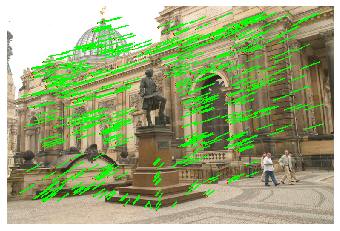

In [139]:
display_4_1()

SURF, min hessian = 400
Matching features: 2182


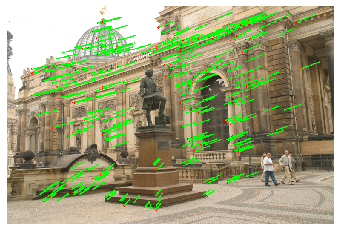

ORB
Matching features: 292


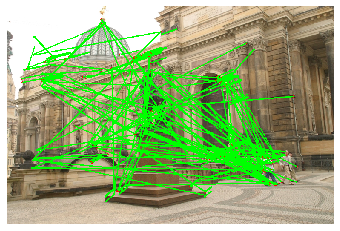

In [144]:
display_4_2()

Above we can see, in the 300 closest matches (by distance between points on semper0), that in the SURF example, there are far more matches than in the ORB example. More importantly there are far more matches that look as if they are correct. It is for that reason that I chose the SURF algorithm.

SURF, min hessian = 400
Matching features: 2182


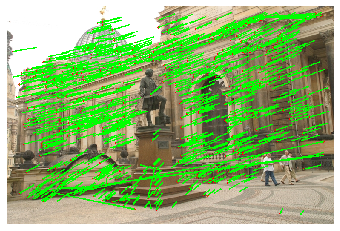

SURF, min hessian = 300
Matching features: 2588


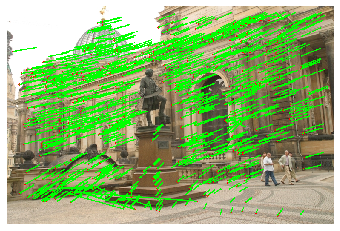

SURF, min hessian = 200
Matching features: 3240


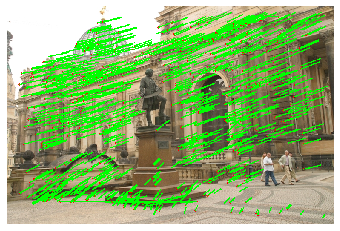

SURF, min hessian = 100
Matching features: 4280


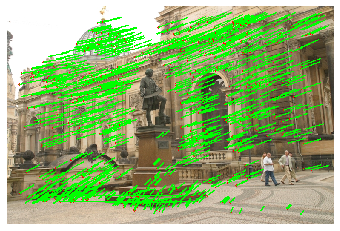

SURF, min hessian = 50
Matching features: 5006


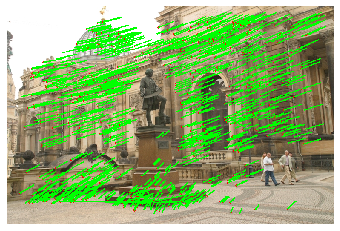

In [145]:
change_hessian(1000)

In the above examples, I have decremented the hessian threshold to try and find a point where incorrect matches start to appear. to illustrate this I have drawn the first 1000 matching feature vectors that have the shortest distance between the two images.

It is clear that 400 is too high of a threshold, but there is no clear improvement when the threshold is lower than 100. I have therefore chosen the hessian threshold as 100.

## Question 5
Test the robustness of your feature detector and matcher against scale variation, as follows. Select a
suitable test image A. Resize this image using your function from problem 3, and call the result B.
Now find features in A and B, match them, and measure the repeatability of the detection as well as the
accuracy of the matching. You should automate the process so that you can generate results for many
scale factors (e.g. 0.1 to 3 in steps of 0.1). Plot two graphs (repeatability vs scale factor, accuracy vs scale
factor), show a few typical results (detected features and matches over an image pair), and discuss.

In [97]:
minHessian = 100
arc = plt.imread("arc.jpg")
arc_scale = {}
count = 1
scale = 1
while scale < 2:
    scale = count * 0.1
    count += 1
    print("Scale: {}".format(scale))
    arc_scale[scale] = nn_resize(arc, scale)
    

Scale: 0.1
Starting Nearest Neighbour
Done resizing
Scale: 0.2
Starting Nearest Neighbour
Done resizing
Scale: 0.30000000000000004
Starting Nearest Neighbour
Done resizing
Scale: 0.4
Starting Nearest Neighbour
Done resizing
Scale: 0.5
Starting Nearest Neighbour
Done resizing
Scale: 0.6000000000000001
Starting Nearest Neighbour
Done resizing
Scale: 0.7000000000000001
Starting Nearest Neighbour
Done resizing
Scale: 0.8
Starting Nearest Neighbour
Done resizing
Scale: 0.9
Starting Nearest Neighbour
Done resizing
Scale: 1.0
Starting Nearest Neighbour
Done resizing
Scale: 1.1
Starting Nearest Neighbour
Done resizing
Scale: 1.2000000000000002
Starting Nearest Neighbour
Done resizing
Scale: 1.3
Starting Nearest Neighbour
Done resizing
Scale: 1.4000000000000001
Starting Nearest Neighbour
Done resizing
Scale: 1.5
Starting Nearest Neighbour
Done resizing
Scale: 1.6
Starting Nearest Neighbour
Done resizing
Scale: 1.7000000000000002
Starting Nearest Neighbour
Done resizing
Scale: 1.8
Starting Neare

Scale: 0.1
Matching features: 2265


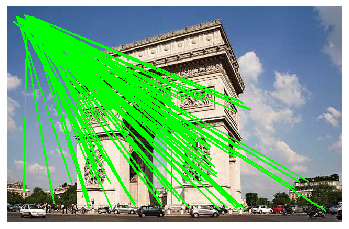

Scale: 0.2
Matching features: 1771


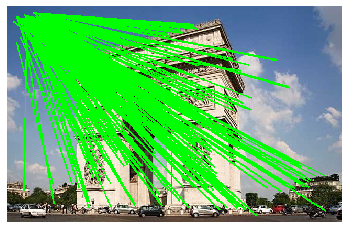

Scale: 0.30000000000000004
Matching features: 1466


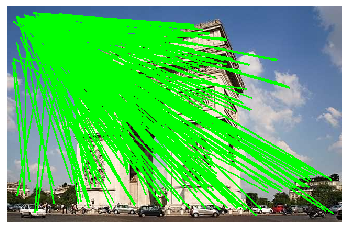

Scale: 0.4
Matching features: 1262


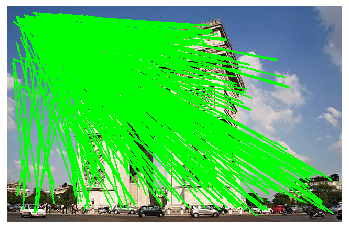

Scale: 0.5
Matching features: 1096


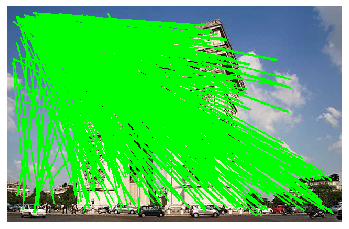

Scale: 0.6000000000000001
Matching features: 985


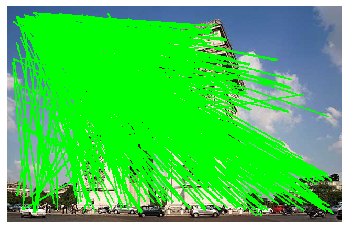

Scale: 0.7000000000000001
Matching features: 863


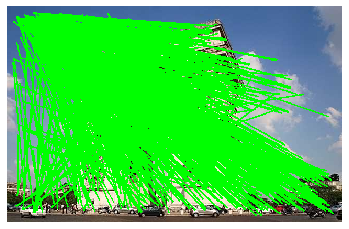

Scale: 0.8
Matching features: 733


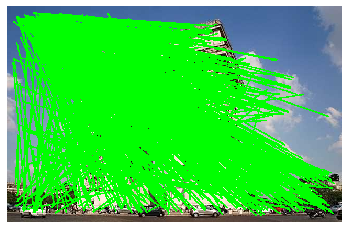

Scale: 0.9
Matching features: 637


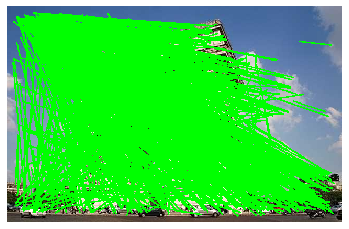

Scale: 1.0
Matching features: 487


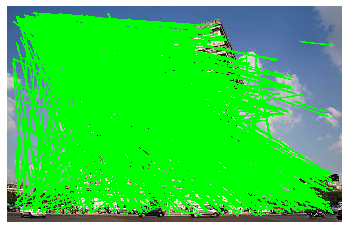

Scale: 1.1
Matching features: 498


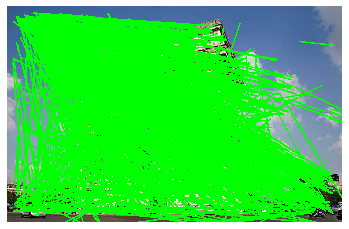

Scale: 1.2000000000000002
Matching features: 316


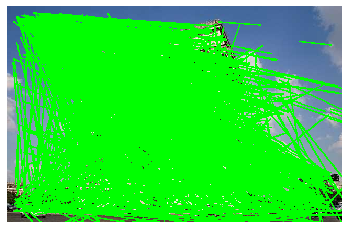

Scale: 1.3
Matching features: 201


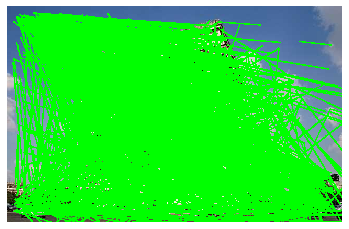

Scale: 1.4000000000000001
Matching features: 112


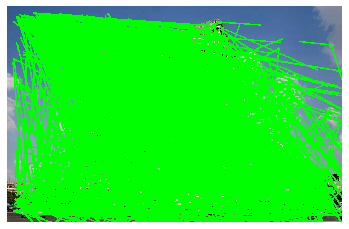

Scale: 1.5
Matching features: 70


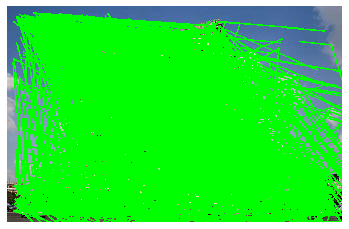

Scale: 1.6
Matching features: 40


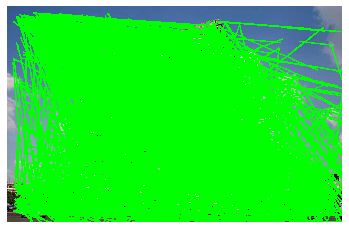

Scale: 1.7000000000000002
Matching features: 37


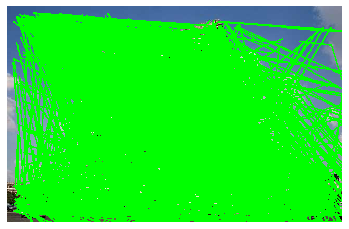

Scale: 1.8
Matching features: 44


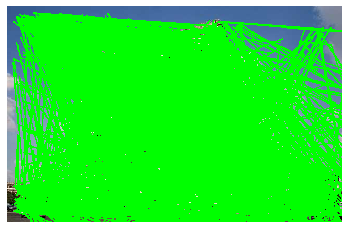

Scale: 1.9000000000000001
Matching features: 32


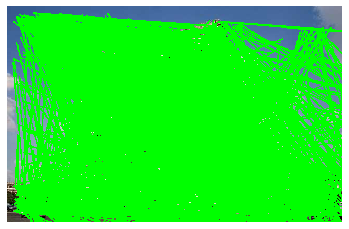

Scale: 2.0
Matching features: 18


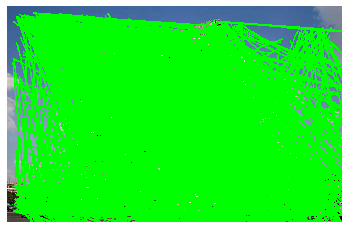

In [98]:
clear = arc_scale[1.0]
for image in arc_scale:
    base = clear
    print("Scale: {}".format(image))
    get_matches_surf(surf, base, arc_scale[image], 100)